# Assignment 9 (Exercise 9.3)

## Simon Laurent Lebailly, 2549365, s9sileba@teams.uni-saarland.de
## Christian Mathieu Schmidt, 2537621, s9cmscmi@teams.uni-saarland.de



### In the lecture you have been introduced to VGG16. For this problem your task is to implement a VGG like CNN architecture for classification on the CIFAR10 dataset.

In [128]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

### 1. Load the dataset (0.5 point)
To load the dataset, you can use the inbuilt dataloader for CIFAR10 provided in the torchvision package. Load both test set and trainset separately. Define the transformations you might need to load the data appropriately.

In [129]:
#Import datasets from torchvision to import the CIFAR10 dataset
from torchvision import datasets


#Check if CUDA is available, if not use the CPU. 
#We have worked on a PC (CUDA available) and a Macbook (CUDA not available), so we have used both.
#Therefore we have implemented a case distinction, and we have modified the code where necessary.
train_on_GPU = torch.cuda.is_available()
device = torch.device('cuda' if train_on_GPU else 'cpu')

if train_on_GPU:
    print('CUDA available!')
else:
    print('CUDA not available!')


#Hyperparameters:
batch_size = 4
learning_rate = 0.01



transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

trainset = datasets.CIFAR10('data', train=True, download=True, transform=transform)
quantity_train = len(trainset)
print('Quantity training data: '+ str(quantity_train))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)


testset = datasets.CIFAR10('data', train=False, download=True, transform=transform)
quantity_test = len(testset)
print('Quantity test data: '+ str(quantity_test))

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


CUDA not available!
Files already downloaded and verified
Quantity training data: 50000
Files already downloaded and verified
Quantity test data: 10000


### Create the model architecture (1.0 point)
Implement the class below such that the final architecture follows the same pattern of layers as VGG16.

In [130]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #Pooling filter with size 2x2, to halve the size of the image
        self.pool = nn.MaxPool2d(2,2)        
        
        #First VGG layer with two times Convolution and duplicating of the features
        self.conv11 = nn.Conv2d(3,16,3)
        self.conv12 = nn.Conv2d(16,16,3)
        
        #Second VGG layer with three times Convolution and duplicating of the features
        self.conv21 = nn.Conv2d(16,32,3)
        self.conv22 = nn.Conv2d(32,32,3)
        self.conv23 = nn.Conv2d(32,32,3)
        
        #Third VGG layer with fully connected layers
        self.fc1 = nn.Linear(32*4*4, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 10)
        

    def forward(self, x):
        #First VGG layer with two times Convolution + ReLu and duplicating of the features
        #Pooling filter with size 2x2, to halve the size of the image, after the second convolution
        out = F.relu(self.conv11(x))
        out = self.pool(F.relu(self.conv12(out)))
        
        #Second VGG layer with three times Convolution + ReLu and duplicating of the features
        #Pooling filter with size 2x2, to halve the size of the image, after the third convolution
        out = F.relu(self.conv21(out))
        out = F.relu(self.conv22(out))
        out = self.pool(F.relu(self.conv23(out)))
        
        #Third VGG layer with fully connected layers
        out = out.view(-1, 32*4*4)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        
        #We don't use SOFTMAX in the forward process, because we use CrossEntropyLoss() as criterion
        
        return out


net = Net().to(device)


### Loss function and optimizer (0.5 point)
Define the loss function and optimizer to train the model.

In [131]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

### Train the model (1.0 point)

Progress: 0.5%, Epoch: 1, Datasets: 1000, Loss: 2.323392391204834, Mean Loss: 2.323392391204834
Progress: 1.0%, Epoch: 1, Datasets: 2000, Loss: 2.309980630874634, Mean Loss: 2.316686511039734
Progress: 1.5%, Epoch: 1, Datasets: 3000, Loss: 2.2914302349090576, Mean Loss: 2.3082677523295083
Progress: 2.0%, Epoch: 1, Datasets: 4000, Loss: 2.295027017593384, Mean Loss: 2.3049575686454773
Progress: 2.5%, Epoch: 1, Datasets: 5000, Loss: 2.308342456817627, Mean Loss: 2.305634546279907
Progress: 3.0%, Epoch: 1, Datasets: 6000, Loss: 2.3049771785736084, Mean Loss: 2.305524984995524
Progress: 3.5%, Epoch: 1, Datasets: 7000, Loss: 2.310007095336914, Mean Loss: 2.3061652864728654
Progress: 4.0%, Epoch: 1, Datasets: 8000, Loss: 2.316352367401123, Mean Loss: 2.3074386715888977
Progress: 4.5%, Epoch: 1, Datasets: 9000, Loss: 2.3493285179138184, Mean Loss: 2.3120930989583335
Progress: 5.0%, Epoch: 1, Datasets: 10000, Loss: 1.6929268836975098, Mean Loss: 2.250176477432251
Progress: 5.5%, Epoch: 1, Data

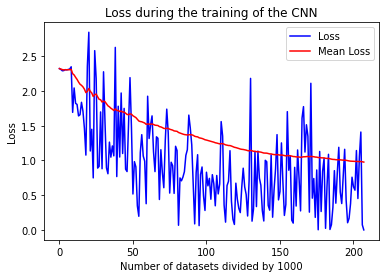

In [132]:
#Import matplotlib to show the course of the loss
import matplotlib.pyplot as plt

#Two lists  only used for the plot and the statistics
lossdata = []
mean_lossdata = []

#We have used 16 epochs, because we had the best results (actual >= 70% accuracy total) in dependence of the time the CNN needs to train (ca. 20min).
epochs = 16

for epoch in range(epochs):
    for i, data in enumerate(trainloader, 0):
        #"Transport" the data to CUDA if available, and otherwise to the CPU
        image = data[0].to(device)
        label = data[1].to(device)
        
        #Compute the forward propagation
        output = net(image)
        
        #Compute the train loss
        loss = criterion(output, label)
        
        #Reset gradient and execute backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #Print statistics
        if ((i+1) % 1000 == 0) or ((i+1) % (50000/batch_size) == 0):
            lossdata.append(loss.item())
            mean_loss = sum(lossdata)/len(lossdata)
            mean_lossdata.append(mean_loss)
            
            print("Progress: " + str(round(((((i+1)+epoch*12000)*100)/((50000/batch_size)*epochs)), 2)) + "%, Epoch: " + str(epoch+1) 
                  + ", Datasets: " + str((i+1)+epoch*12000) + ", Loss: " + str(loss.item()) + ", Mean Loss: " + str(mean_loss))


print('Finished Training')

#Plot the train loss function
plt.title("Loss during the training of the CNN")
plt.plot(lossdata,'-b',label='Loss')
plt.plot(mean_lossdata,'-r',label='Mean Loss')
plt.xlabel('Number of datasets divided by 1000')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


Code below generates the class wise accuracy of the model. You can use the results from the code below to decide the values of hyperparametrs.

In [133]:

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        #We have set .cuda() to .to(device) because of the different systems we have used.
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


total_class = 0
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    total_class += class_correct[i]


#We have added the value of the overall accuracy.
total = 100 * total_class / (len(testloader)*batch_size)

print(" ")
print('Accuracy total: ' + str(total) + '%')


Accuracy of plane : 65 %
Accuracy of   car : 78 %
Accuracy of  bird : 54 %
Accuracy of   cat : 45 %
Accuracy of  deer : 75 %
Accuracy of   dog : 57 %
Accuracy of  frog : 79 %
Accuracy of horse : 75 %
Accuracy of  ship : 87 %
Accuracy of truck : 83 %
 
Accuracy total: 70.31%
